##  <b>Plant Seedling Classification

### **Context:**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.




### **Objective:**

The aim of this project is to **Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.**


### **Data Description:**
The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet




####**Note: Please use GPU runtime to execute the code efficiently** 


### Importing necessary libraries

In [1]:
import torch
if torch.cuda.is_available():
    torch.zeros(100).cuda()
    print('CUDA is working')
else:
    print('No CUDA')

CUDA is working


In [2]:
# environment variable: 'vsc' or 'colab'
ENV = 'vsc'

In [3]:
import numpy as np
import pandas as pd
import time
import sys
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, SpatialDropout2D, LeakyReLU, ReLU

2023-01-21 11:28:58.039838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 11:28:58.748493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/peacelovephysics/ut_ai_computer_vision_seedling_classifier_project/.venv2/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-21 11:28:58.748593: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home

In [4]:
start_time = time.time()

### Mounting drive

In [5]:
if ENV == 'colab':
    # Mounting the Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

### Read the dataset

In [6]:
if ENV == 'vsc':
    images = np.load('images.npy') 
    with open('Labels.csv', 'r') as label_file:
        labels = np.array(pd.read_csv(label_file))[:,0]
elif ENV == 'colab':
    images = np.load('/content/drive/images.npy')
    labels = np.array(pd.read_csv('/content/drive/Labels.csv'))[:,0]
else:
    print("bad ENV type.....")
    sys.exit()

### Data Overview

- Check the shape of images and the labels in the data
- Converting images from BGR to RGB

#### Checking the shape of the dataset

In [7]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750,)


#### Converting the BGR images to RGB images.

In [8]:
for index in range(images.shape[0]):
    images[index, :, :, :] = cv2.cvtColor(images[index, :, :, :], cv2.COLOR_BGR2RGB)

### Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better. 
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

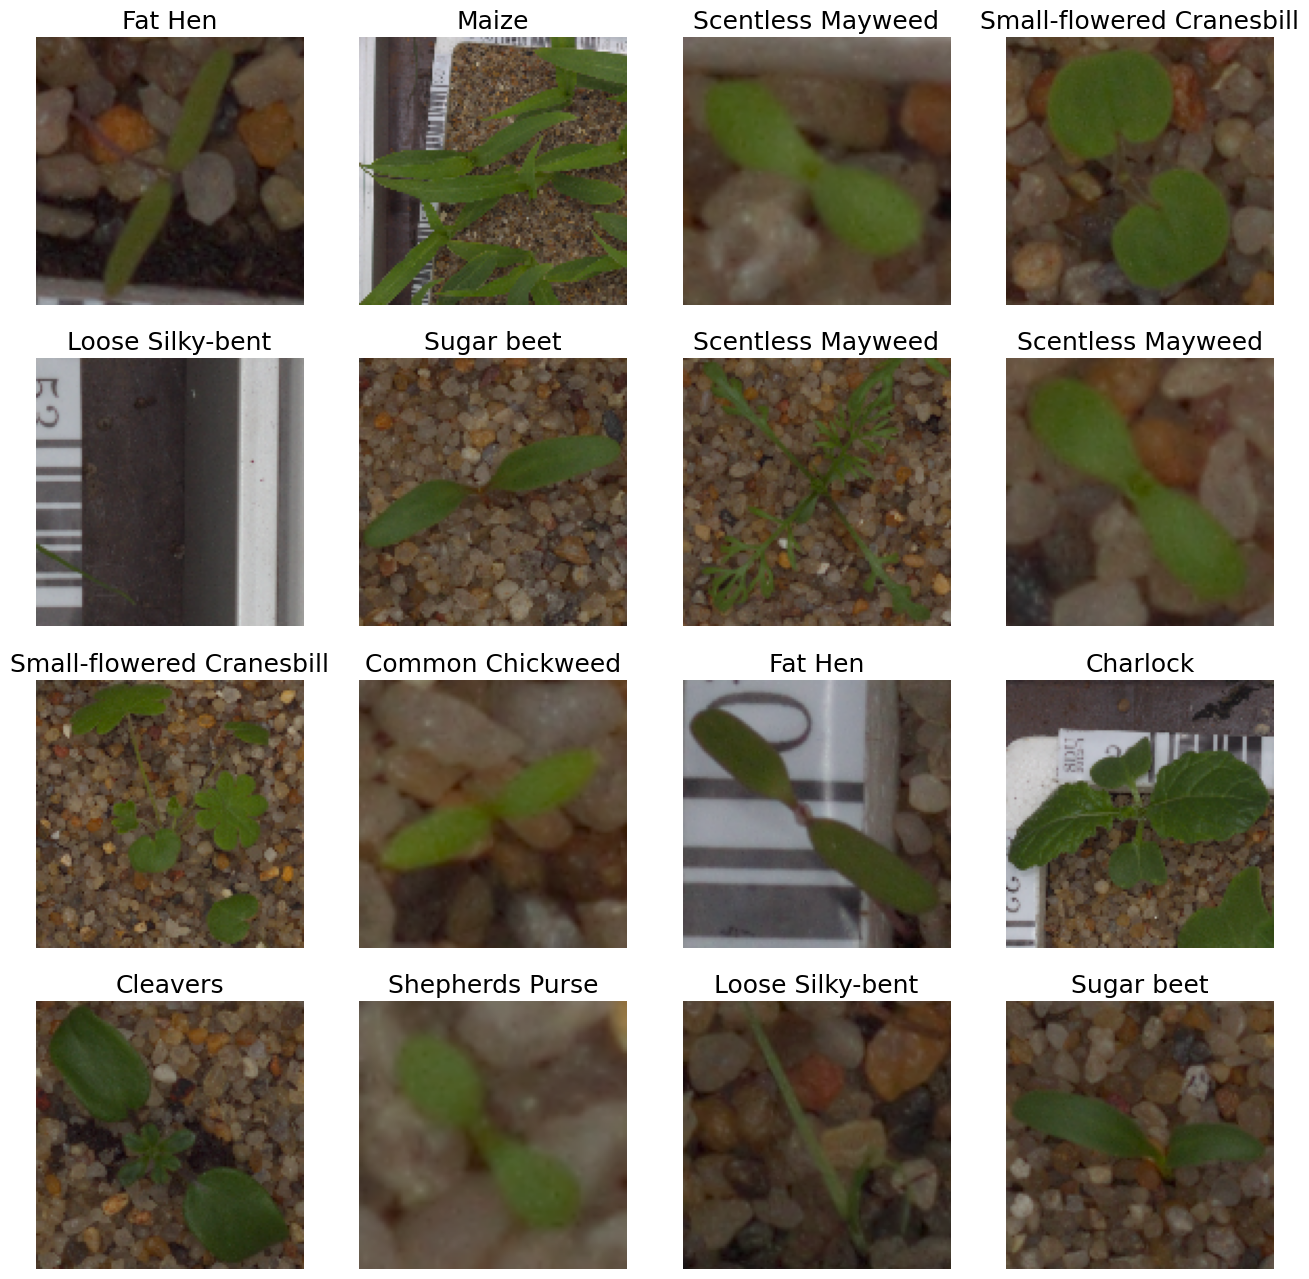

In [9]:
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, images.shape[0], 1))
    plt.title(labels[index], fontsize = 18)
    plt.imshow(images[index, :, :, :])
    plt.axis('off')

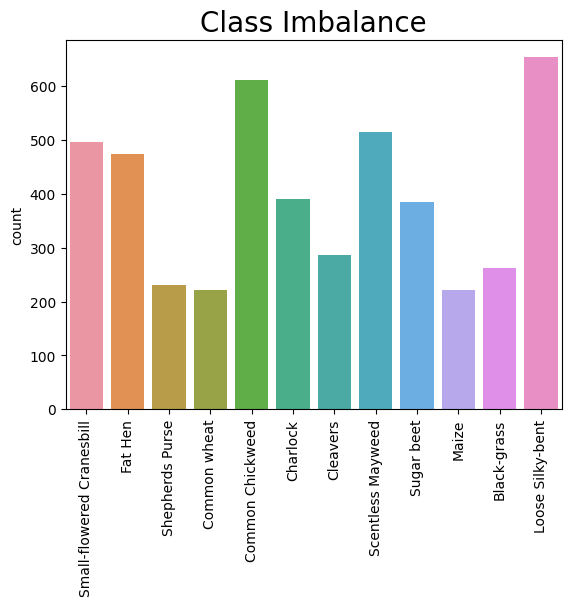

In [88]:
ax = sns.countplot(x = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.title('Class Imbalance', fontsize = 20)
plt.show()

**Observations:**
- Some photos are out of focus or blurry
- some photos have a higher exposure or brightness than others
- some photos include rulers or backgrounds other than soil (e.g., containers)
- There is a fairly strong class imbalance
    - Lowest frequency classes: 
        - Shepherds Purse
        - Common Wheat
        - Maize 
        - Black-grass
    - Highest frequency classes:
        - Loose Silky-bent
        - Common Chickweed
        - Scentless Mayweed
        - Small-flowered Canesbill
        - Fat Hen

### Resizing images 
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [10]:
images64 = np.empty((images.shape[0], 64, 64, 3), dtype = 'uint8')
for index in range(images.shape[0]):
    images64[index, :, :, :] = cv2.resize(images[index,:, :, :], (64, 64), interpolation = cv2.INTER_LINEAR)

### Data Preparation for modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

#### Encoding the target labels

In [11]:
y = pd.get_dummies(labels)
print(y.shape)

(4750, 12)


#### Data Normalization (Scaling)

In [12]:
images = images64 / 255.
print(np.min(images), np.max(images))

0.0 1.0


#### Splitting the dataset

In [13]:
X_train, X_val0, y_train, y_val0 = train_test_split(images, y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val0, y_val0, test_size = 0.5)

In [14]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3325, 64, 64, 3) (3325, 12)
(712, 64, 64, 3) (712, 12)
(713, 64, 64, 3) (713, 12)


### Model Building - Convolutional Neural Network (CNN)


First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data. 

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.



#### Clearing the backend session and initializing the random seed values

In [15]:
#Clearing backend
backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Model Buidling (CNN)

In [16]:
model0 = Sequential()

# first conv layer
model0.add(Conv2D(64, (3, 3), name = 'Conv_1', activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same', input_shape = (64, 64, 3)))
# first pooling layer
model0.add(MaxPool2D(pool_size = (2, 2), name = 'Pool_1'))
# second conv layer
model0.add(Conv2D(32, (3, 3), name = 'Conv_2', activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same')) 
# second pooling layer
model0.add(MaxPool2D(pool_size = (2, 2), name = 'Pool_2'))
# third conv layer
model0.add(Conv2D(16, (3, 3), name = 'Conv_3', activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
# third pooling layer
model0.add(MaxPool2D(pool_size = (2, 2), name = 'Pool_3'))

# flatten
model0.add(Flatten())

# first dense layer
model0.add(Dense(64, name = 'Dense_1', activation = 'relu'))
# second dense layer
model0.add(Dense(32, name = 'Dense_2', activation = 'relu'))
# third dense layer
model0.add(Dense(16, name = 'Dense_3', activation = 'relu'))
# output layer
model0.add(Dense(12, name = 'Output_Layer', activation = 'softmax'))

2023-01-21 11:29:02.305708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-21 11:29:02.346159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-21 11:29:02.346202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-21 11:29:02.347176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [17]:
# compile
model0.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(learning_rate=0.0005), metrics = ['accuracy'])

#### Summary of the model

In [18]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 Pool_1 (MaxPooling2D)       (None, 32, 32, 64)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 32, 32, 32)        18464     
                                                                 
 Pool_2 (MaxPooling2D)       (None, 16, 16, 32)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 16, 16, 16)        4624      
                                                                 
 Pool_3 (MaxPooling2D)       (None, 8, 8, 16)          0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

#### Fitting the model on the train data

In [19]:
# define callbacks
callbacks0 = [
    ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True), 
    EarlyStopping(monitor='val_loss', patience = 10)
]

In [20]:
model0_history = model0.fit(
    X_train, 
    y_train, 
    validation_data = (X_val, y_val), 
    epochs = 50, 
    batch_size = 16, 
    callbacks = callbacks0
)

Epoch 1/50


2023-01-21 11:29:04.868179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-01-21 11:29:05.415632: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f54c8835630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-21 11:29:05.415682: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2023-01-21 11:29:05.420064: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-21 11:29:05.512873: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/208 [==============================] - 6s 14ms/step - loss: 2.2959 - accuracy: 0.2039 - val_loss: 1.9817 - val_accuracy: 0.3624
Epoch 2/50
208/208 [==============================] - 2s 11ms/step - loss: 1.7764 - accuracy: 0.3889 - val_loss: 1.8217 - val_accuracy: 0.3708
Epoch 3/50
208/208 [==============================] - 2s 12ms/step - loss: 1.4473 - accuracy: 0.4917 - val_loss: 1.4449 - val_accuracy: 0.5267
Epoch 4/50
208/208 [==============================] - 3s 12ms/step - loss: 1.1846 - accuracy: 0.5844 - val_loss: 1.1418 - val_accuracy: 0.6278
Epoch 5/50
208/208 [==============================] - 3s 12ms/step - loss: 1.0295 - accuracy: 0.6388 - val_loss: 1.0548 - val_accuracy: 0.6643
Epoch 6/50
208/208 [==============================] - 3s 12ms/step - loss: 0.9069 - accuracy: 0.6911 - val_loss: 0.9326 - val_accuracy: 0.6868
Epoch 7/50
208/208 [==============================] - 3s 12ms/step - loss: 0.7853 - accuracy: 0.7272 - val_loss: 0.9165 - val_accuracy: 0.6742
Epoch 8/50

#### Model Evaluation

In [21]:
evaluation = model0.evaluate(X_val, y_val, verbose = 1)

print('\n', 'Evaluation metric score:', evaluation[1])

23/23 [==============================] - 0s 6ms/step - loss: 1.1739 - accuracy: 0.7219

 Evaluation metric score: 0.7219101190567017


In [22]:
def plot_loss(history):
    N = len(history.history["loss"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss", ls='--')
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss", ls='--')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")

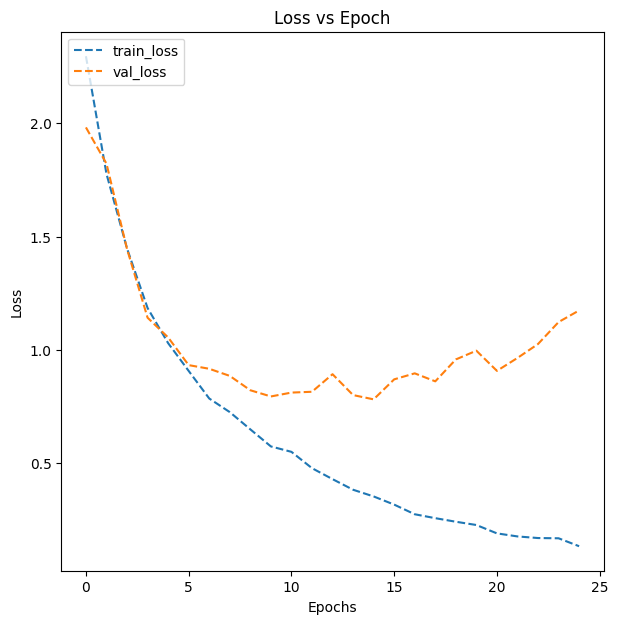

In [23]:
plot_loss(model0_history)

In [24]:
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

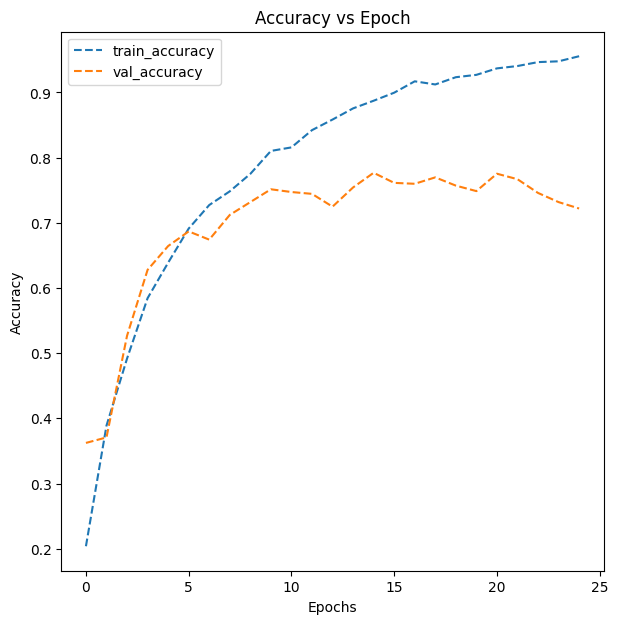

In [25]:
plot_accuracy(model0_history)

**Observations:** 
- The initial model performs with 72% accuracy on the train dataset 
- The validation loss has reached a minimum, so the model has been sufficiently optimized

#### Evaluating the model on test data

In [26]:
evaluation = model0.evaluate(X_test, y_test, verbose = 1)

print('\n', 'Evaluation metric score:', evaluation[1])

23/23 [==============================] - 0s 10ms/step - loss: 1.2424 - accuracy: 0.7335

 Evaluation metric score: 0.7335203289985657


#### Plot the Confusion Matrix





*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





In [27]:
pred0 = model0.predict(X_test)

23/23 [==============================] - 0s 3ms/step


In [28]:
pred0 = np.argmax(pred0, axis = 1) 
y_true = np.argmax(np.array(y_test), axis = 1)

In [29]:
#Plotting the heatmap using confusion matrix
def plot_confusion_matrix(y_true, pred):
    cm = confusion_matrix(y_true, pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.0f') # , xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

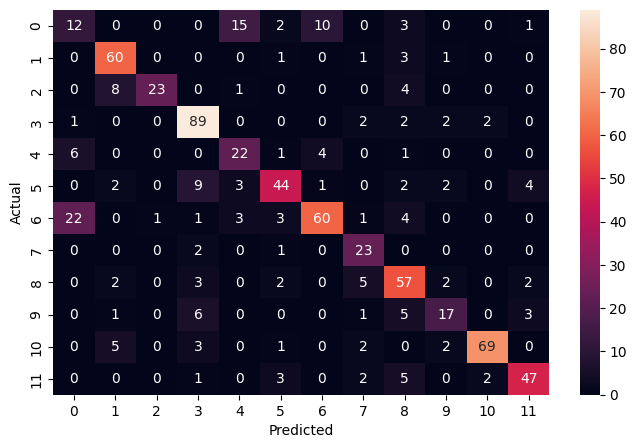

In [30]:
plot_confusion_matrix(y_true = y_true, pred = pred0)

**Observations**:
- The initial model performs with 73% accuracy on the test dataset
- The 0 class is clearly highly misclassified compared to the other classes

#### Plot Classification Report





In [31]:
# Printing the classification report
print(classification_report(y_true, pred0))

              precision    recall  f1-score   support

           0       0.29      0.28      0.29        43
           1       0.77      0.91      0.83        66
           2       0.96      0.64      0.77        36
           3       0.78      0.91      0.84        98
           4       0.50      0.65      0.56        34
           5       0.76      0.66      0.70        67
           6       0.80      0.63      0.71        95
           7       0.62      0.88      0.73        26
           8       0.66      0.78      0.72        73
           9       0.65      0.52      0.58        33
          10       0.95      0.84      0.89        82
          11       0.82      0.78      0.80        60

    accuracy                           0.73       713
   macro avg       0.71      0.71      0.70       713
weighted avg       0.75      0.73      0.73       713



**Observations**:
- As noted above, the f1-score is lowest for the 0 class (worst combined precision & recall)
- lowest precision classes: 0, 4, 7, 9, 8
- lowest recall classes: 0, 9, 6, 2, 4, 5
- lowest f1-score classes: 0, 4, 9

### Deleting the model and history variable to use the RAM efficiently

In [32]:
del model0, model0_history

# **Improving the Base Model using Data Augmentation and Regularization**




**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**


Remember, **data augmentation should not be used in the validation/test data set**.

#### Clearing the backend session and initializing the random seed values

In [33]:
#Clearing backend
backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Model Buidling - 2

In [34]:
model1 = Sequential()

# stack 1
model1.add(Conv2D(16, (3, 3), name = 'Conv_1a', kernel_initializer = 'he_uniform', padding = 'same', input_shape = (64, 64, 3)))
model1.add(Conv2D(16, (3, 3), name = 'Conv_1b', kernel_initializer = 'he_uniform', padding = 'same'))
model1.add(BatchNormalization(name = 'BN_1'))
model1.add(ReLU(negative_slope = 0.02, name = 'ReLU_1'))
model1.add(MaxPool2D(pool_size = (2, 2), name = 'Pool_1'))
model1.add(SpatialDropout2D(rate = 0.2, name = 'Dropout_1'))

# stack 2
model1.add(Conv2D(32, (3, 3), name = 'Conv_2a', kernel_initializer = 'he_uniform', padding = 'same'))
model1.add(Conv2D(32, (3, 3), name = 'Conv_2b', kernel_initializer = 'he_uniform', padding = 'same'))
model1.add(ReLU(negative_slope = 0.02, name = 'ReLU_2'))
model1.add(MaxPool2D(pool_size = (2, 2), name = 'Pool_2'))

# stack 3
model1.add(Conv2D(64, (3, 3), name = 'Conv_3a', kernel_initializer = 'he_uniform', padding = 'same'))
model1.add(Conv2D(64, (3, 3), name = 'Conv_3b', kernel_initializer = 'he_uniform', padding = 'same'))
model1.add(ReLU(negative_slope = 0.02, name = 'ReLU_3'))
model1.add(MaxPool2D(pool_size = (2, 2), name = 'Pool_3'))
model1.add(SpatialDropout2D(rate = 0.2, name = 'Dropout_3'))

model1.add(Flatten())

# Dense Layer 1
model1.add(Dense(64, name = 'Dense_1', activation = 'relu', kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4))) 
model1.add(Dropout(0.2, name = 'Dropout_dense_1'))

# Dense Layer 2
model1.add(Dense(32, name = 'Dense_2', activation = 'relu', kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4))) 
model1.add(Dropout(0.2, name = 'Dropout_dense_2'))

# Dense Layer 3
model1.add(Dense(16, name = 'Dense_3', activation = 'relu', kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4))) 
model1.add(Dropout(0.2, name = 'Dropout_dense_3'))

# Output Layer
model1.add(Dense(12, name = 'Output_Layer', activation = 'softmax'))

In [35]:
model1.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(learning_rate=0.00025), metrics = ['accuracy'])

In [36]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1a (Conv2D)            (None, 64, 64, 16)        448       
                                                                 
 Conv_1b (Conv2D)            (None, 64, 64, 16)        2320      
                                                                 
 BN_1 (BatchNormalization)   (None, 64, 64, 16)        64        
                                                                 
 ReLU_1 (ReLU)               (None, 64, 64, 16)        0         
                                                                 
 Pool_1 (MaxPooling2D)       (None, 32, 32, 16)        0         
                                                                 
 Dropout_1 (SpatialDropout2D  (None, 32, 32, 16)       0         
 )                                                               
                                                        

#### Fitting the model on the train data

In [37]:
callbacks1 = callbacks0.append(
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2, # default value: 0.1
        patience=5,
        verbose=0,
        mode="auto",
        min_delta=0.01,
        cooldown=0,
        min_lr=0
    )
)

In [38]:
model1_history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, batch_size = 16, callbacks = callbacks0)

Epoch 1/100


2023-01-21 11:30:13.995947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/Dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


208/208 [==============================] - 7s 19ms/step - loss: 2.6309 - accuracy: 0.0983 - val_loss: 2.5455 - val_accuracy: 0.1531 - lr: 2.5000e-04
Epoch 2/100
208/208 [==============================] - 3s 16ms/step - loss: 2.5397 - accuracy: 0.1251 - val_loss: 2.5177 - val_accuracy: 0.1503 - lr: 2.5000e-04
Epoch 3/100
208/208 [==============================] - 3s 16ms/step - loss: 2.4884 - accuracy: 0.1648 - val_loss: 2.3789 - val_accuracy: 0.2374 - lr: 2.5000e-04
Epoch 4/100
208/208 [==============================] - 3s 16ms/step - loss: 2.3954 - accuracy: 0.2078 - val_loss: 2.2478 - val_accuracy: 0.2739 - lr: 2.5000e-04
Epoch 5/100
208/208 [==============================] - 3s 16ms/step - loss: 2.2409 - accuracy: 0.2686 - val_loss: 2.1425 - val_accuracy: 0.3174 - lr: 2.5000e-04
Epoch 6/100
208/208 [==============================] - 3s 16ms/step - loss: 2.1079 - accuracy: 0.2980 - val_loss: 1.9030 - val_accuracy: 0.3483 - lr: 2.5000e-04
Epoch 7/100
208/208 [=========================

#### Model Evaluation

In [39]:
evaluation1 = model1.evaluate(X_val, y_val, verbose = 1)

print('\n', 'Evaluation metric score:', evaluation1[1])

23/23 [==============================] - 0s 8ms/step - loss: 0.7536 - accuracy: 0.8020

 Evaluation metric score: 0.8019663095474243


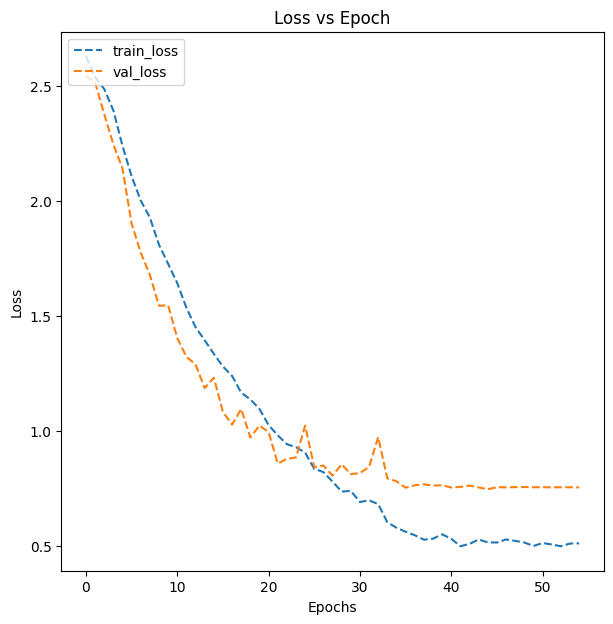

In [40]:
plot_loss(model1_history)

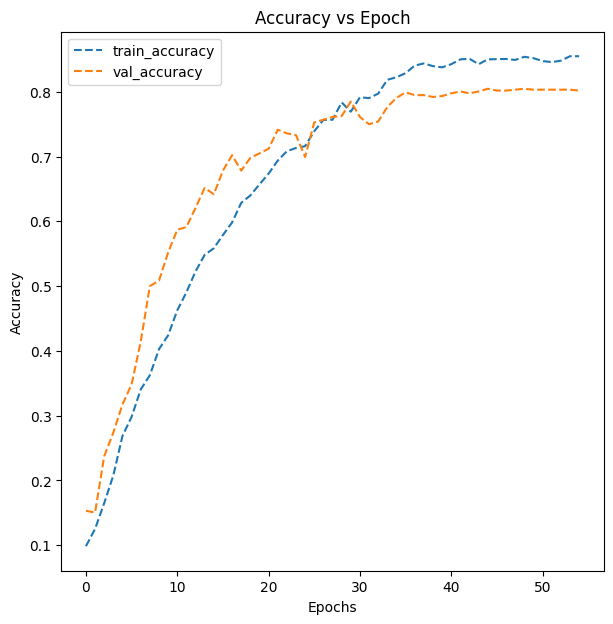

In [41]:
plot_accuracy(model1_history)

#### Evaluating the model on test data

In [42]:
evaluation1 = model1.evaluate(X_test, y_test, verbose = 1)

print('\n', 'Evaluation metric score:', evaluation1[1])

23/23 [==============================] - 0s 14ms/step - loss: 0.7943 - accuracy: 0.7980

 Evaluation metric score: 0.7980364561080933


#### Plotting the Confusion Matrix

In [43]:
pred1 = model1.predict(X_test)
pred1 = np.argmax(pred1, axis = 1) 

23/23 [==============================] - 0s 4ms/step


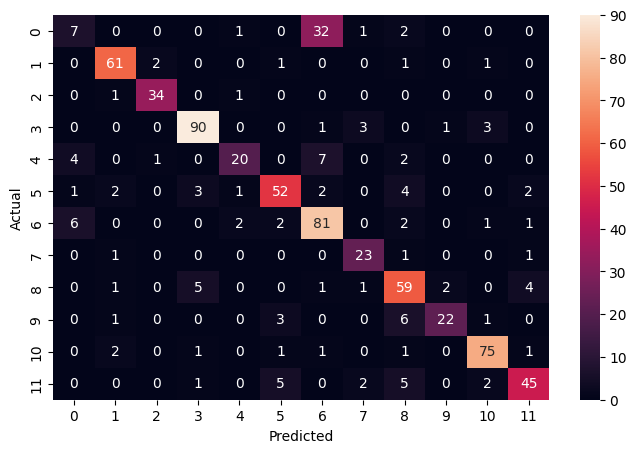

In [47]:
plot_confusion_matrix(y_true = y_true, pred = pred1)

**Observation:**
- The regularized model performs with 80% on the validation dataset and 79% on the test dataset
- class 0 is still the most misclassified class, mostly confused with class 6

#### Plot Classification Report

In [45]:
print(classification_report(y_true, pred1))

              precision    recall  f1-score   support

           0       0.39      0.16      0.23        43
           1       0.88      0.92      0.90        66
           2       0.92      0.94      0.93        36
           3       0.90      0.92      0.91        98
           4       0.80      0.59      0.68        34
           5       0.81      0.78      0.79        67
           6       0.65      0.85      0.74        95
           7       0.77      0.88      0.82        26
           8       0.71      0.81      0.76        73
           9       0.88      0.67      0.76        33
          10       0.90      0.91      0.91        82
          11       0.83      0.75      0.79        60

    accuracy                           0.80       713
   macro avg       0.79      0.77      0.77       713
weighted avg       0.79      0.80      0.79       713



**Observations**:
- class 0 is still the most misclassified class
- worst precision classes: 0, 6
- worst recall classes: 0, 4, 9
- worst f1-score classes: 0, 4

### Visualizing the prediction

In [61]:
# create dictionary for classes / labels
label_dict = dict(list(enumerate(y_test.columns)))
print(label_dict)

{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


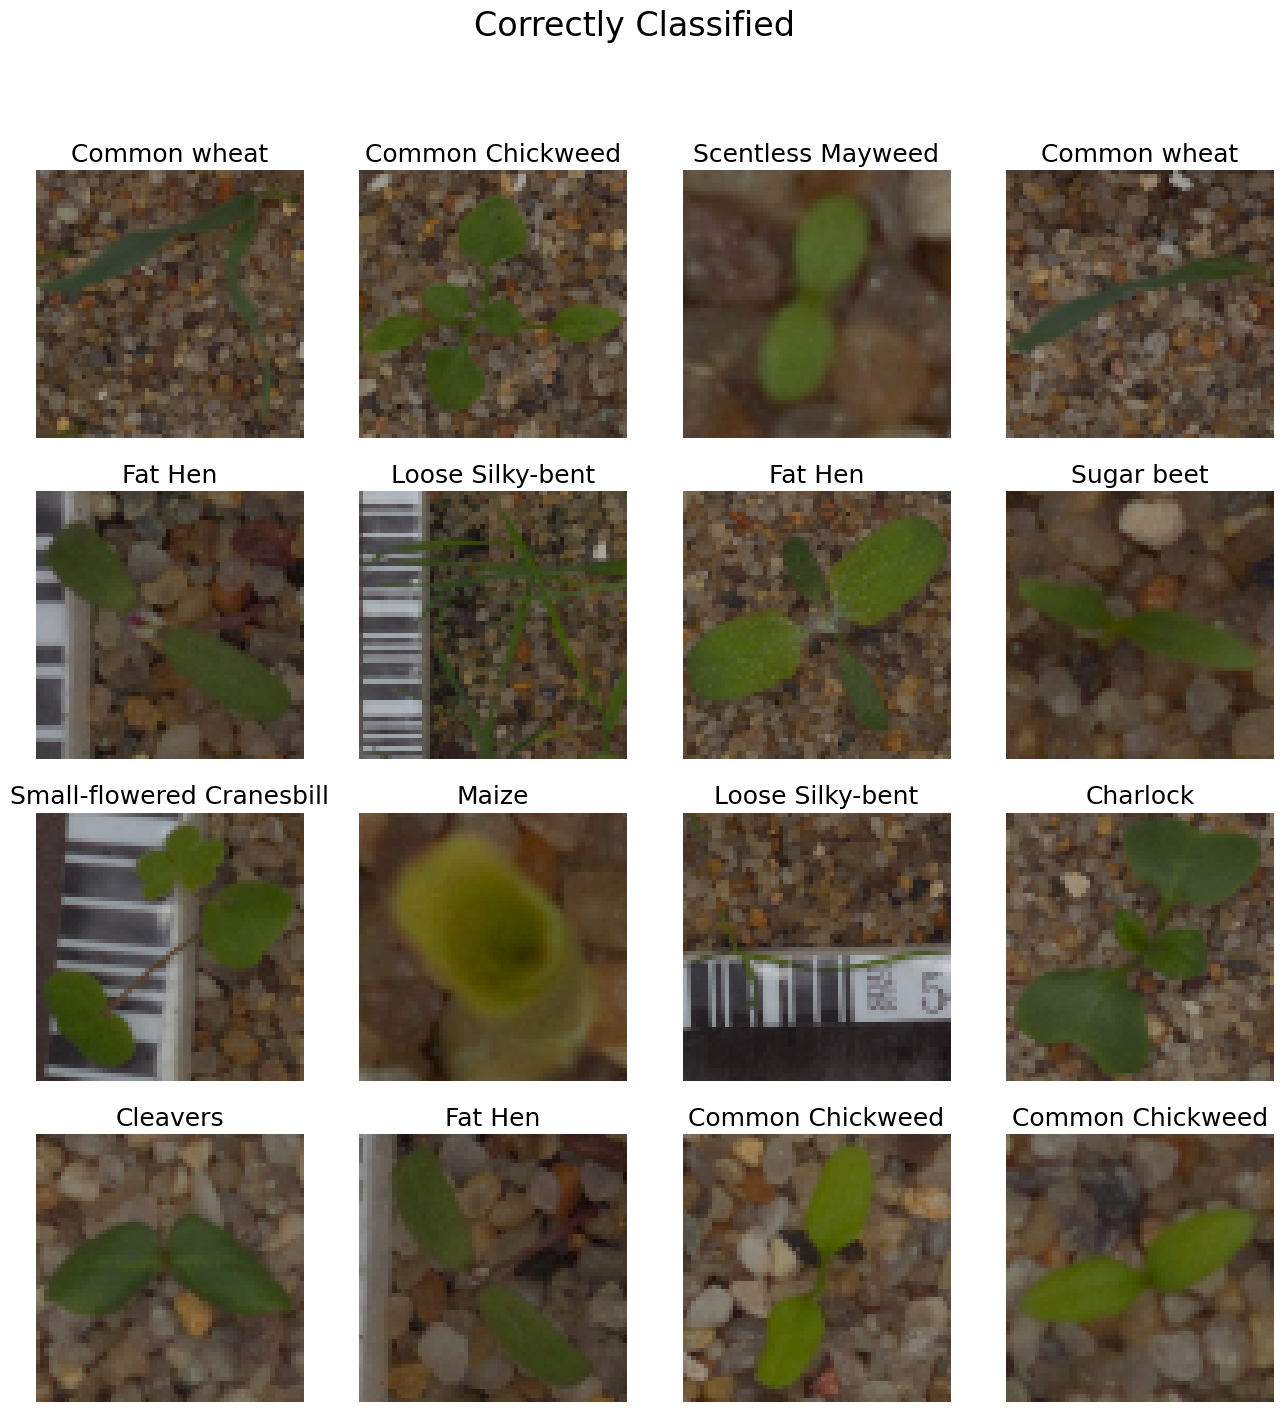

In [67]:
plt.figure(2, figsize = (16 , 16))
for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, X_test.shape[0], 1))
    while pred1[index] != y_true[index]:
        index = int(np.random.randint(0, X_test.shape[0], 1))
    plt.title(label_dict[y_true[index]], fontsize = 18)
    plt.imshow(X_test[index, :, :, :])
    plt.axis('off')
    plt.suptitle('Correctly Classified', fontsize = 24)

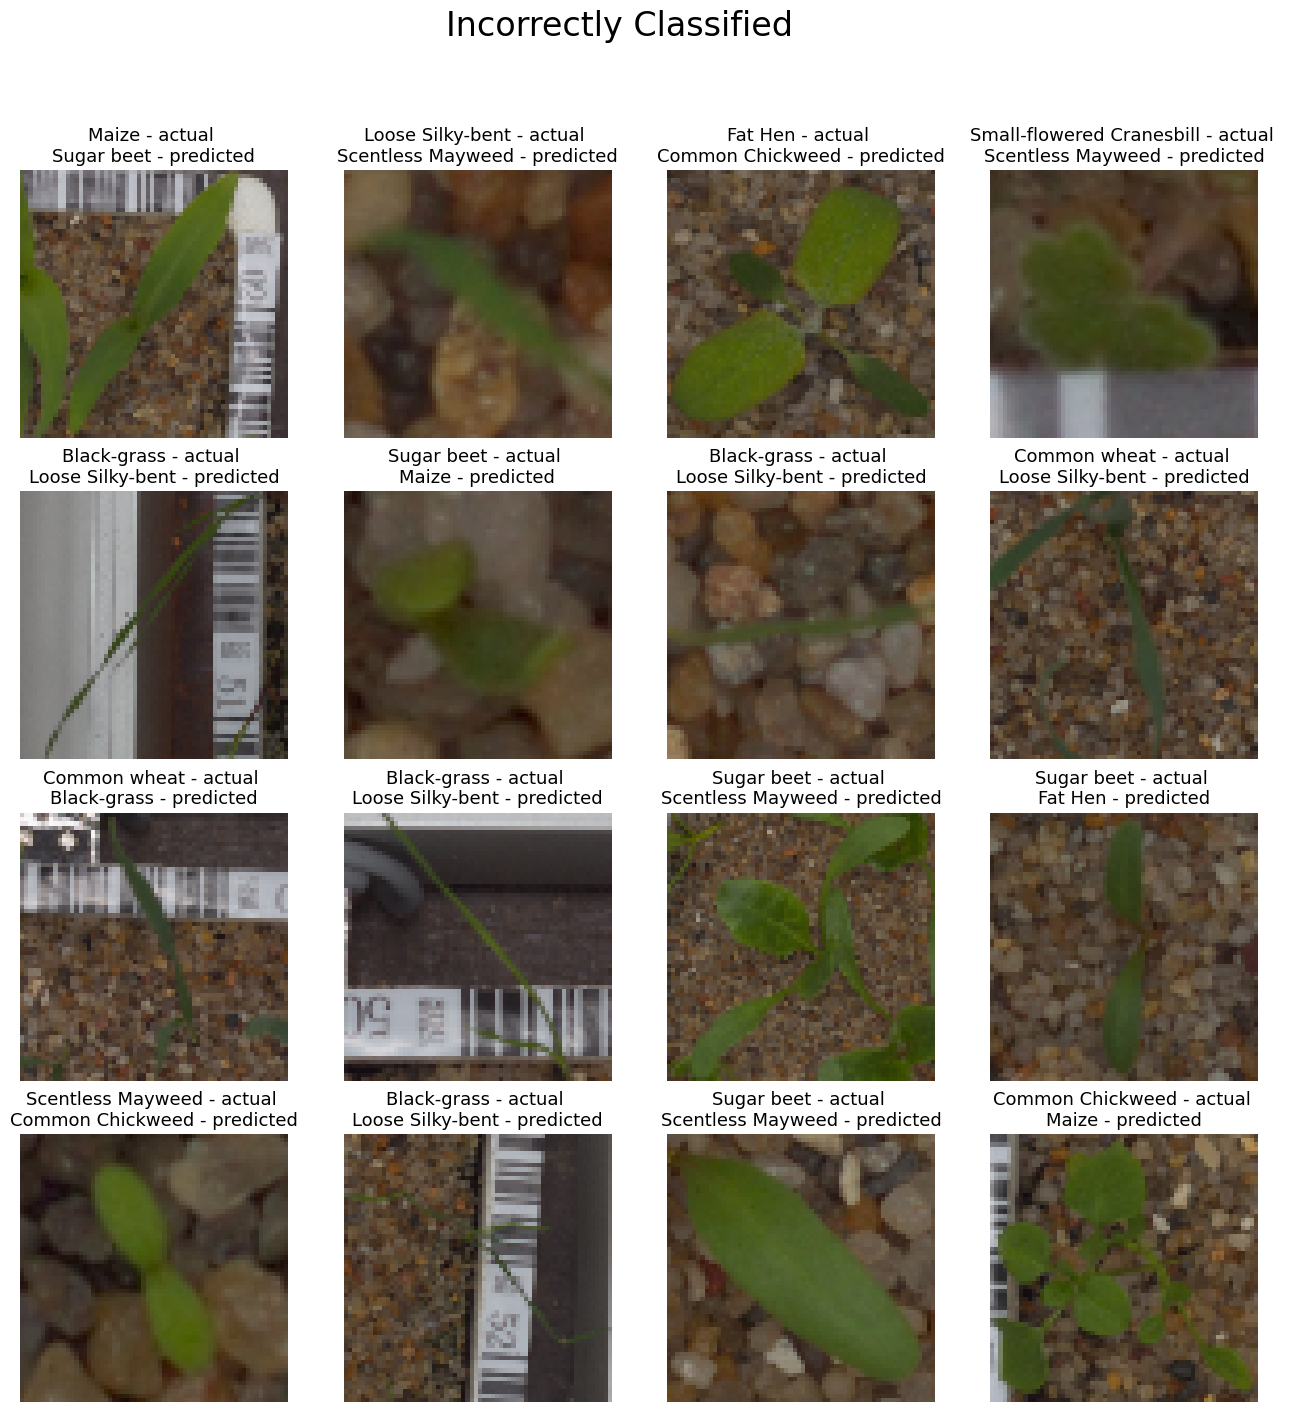

In [68]:
plt.figure(2, figsize = (16 , 16))
for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, X_test.shape[0], 1))
    while pred1[index] == y_true[index]:
        index = int(np.random.randint(0, X_test.shape[0], 1))
    plt.title(f"{label_dict[y_true[index]]} - actual \n{label_dict[pred1[index]]} - predicted", fontsize = 13)
    plt.imshow(X_test[index, :, :, :])
    plt.axis('off')
    plt.suptitle('Incorrectly Classified', fontsize = 24)

**Observations**
- The Black Grass class is often misclassified as the Loose Silky Bent class because they are both long and slender plants 
- Perhaps more features could be distinguished between the two classes if the images were not resized to be smaller
- Data class imbalance may be contributing to the misclassification

## Conclusion
- The initial model performs at 73.4% and the final model performs at 79.8%
- Regularization improved the model performance
- Two classes are difficult to distinguish because they are both long slender grass-type plants
    - Black Grass is the hardest to identify in the model, and is often misclassified as Loose Silky Bent because of class imbalance
- Further refinements could be made by using different metrics in order to try to classify the Black grass and Loose Silky Bent classes more accurately

# **Happy Learning!**

In [46]:
run_time = time.time() - start_time
if run_time < 60.:
    print(f"Overall run time: {run_time:.2f} s")
else:
    mins = int(run_time / 60.)
    secs = run_time % 60.
    print(f"Overall run time: {mins} mins, {secs:.2f} seconds")

Overall run time: 4 mins, 21.31 seconds
